In [1]:
import numpy as np
import pandas as pd
import sobol_seq
import matplotlib.pyplot as plt

Problem 1

In [2]:
m_cluster = 50
gamma = 0.2
epsilon = 10**(-3)
delta = 0.01
k_cluster = 10
m = 250
r = 0.95
theta = np.pi/4
k_max = 250
dim = 2

def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    f_list = [f1,f2]
    denom = 0
    for f in f_list:
        denom +=np.abs(f)
    F = 1/(1+denom)
    return F

boundaries = np.array([(-10,10) for _ in range (dim)])

Problem 2

In [3]:
# m_cluster = 2000
# gamma = 0.3
# epsilon = 10**(-3)
# delta = 0.1
# k_cluster = 10
# m = 300
# r = 0.95
# theta = np.pi/4
# k_max = 300
# dim = 2

# def objective_function(x):
#     f1 = 0.5*np.sin(x[0]*x[1])-0.25*x[1]/np.pi - 0.5*x[0]
#     f2 = (1-0.25/np.pi)*(np.exp(2*x[0])-np.exp(1))+np.exp(1)*x[1]/np.pi - 2*np.exp(1)*x[0]
#     f_list = [f1,f2]
#     denom = 0
#     for f in f_list:
#         denom +=np.abs(f)
#     F = 1/(1+denom)
#     return F

# boundaries = np.array([(-1,3),(-17,4)])

Problem 4

In [4]:
# m_cluster = 2000
# gamma = 0.001
# epsilon = 10**(-1)
# delta = 0.5
# k_cluster = 10
# m = 500
# r = 0.95
# theta = np.pi/4
# k_max = 500
# dim = 3

# def objective_function(x):
#     f1 = x[0]*x[1]-(x[0]-2*x[2])*(x[1]-2*x[2])-165
#     f2 = (x[0]*x[1]**3)/12-((x[0]-2*x[2])*(x[1]-2*x[2])**3)/12-9369
#     f3 = (2*(x[1]-x[2])**2*(x[0]-x[2])**2*x[2])/(x[1]+x[0]-2*x[2])-6835
#     f_list = [f1,f2,f3]
#     denom = 1
#     for f in f_list:
#         denom +=np.abs(f)
#     F = 1/denom
#     return F

# boundaries = np.array([(-40,40) for _ in range (dim)])

Problem 5

In [5]:
# m_cluster = 3000
# gamma = 0.1
# epsilon = 5*10**(-2.5)
# delta = 0.01
# k_cluster = 10
# m = 200
# r = 0.95
# theta = np.pi/4
# k_max = 200
# dim = 5

# def objective_function(x):
#     f1 = 2*x[0]+x[1]+x[2]+x[3]+x[4]-6
#     f2 = x[0]+2*x[1]+x[2]+x[3]+x[4]-6
#     f3 = x[0]+x[1]+2*x[2]+x[3]+x[4]-6
#     f4 = x[0]+x[1]+x[2]+2*x[3]+x[4]-6
#     f5 = x[0]*x[1]*x[2]*x[3]*x[4]-1
#     f_list = [f1,f2,f3,f4,f5]
#     denom = 0
#     for f in f_list:
#         denom +=np.abs(f)
#     F = 1/(1+denom)
#     return F

# boundaries = np.array([(-10,10) for _ in range (dim)])

Supercritical Pitchfork Bifurcation

In [6]:
# m_cluster = 300
# gamma = 0.1
# epsilon = 5*10**(-3)
# delta = 0.01
# k_cluster = 10
# m = 200
# r = 0.95
# theta = np.pi/4
# k_max = 200
# dim=1
# boundaries = np.array([(-9,9) for _ in range (1)])
# d_list = np.linspace(boundaries[0][0],boundaries[0][1],31)
# def objective_function(x):
#     f = d_list[-1]*x-x**3
#     f_list = [f]
#     denom = 1
#     for f in f_list:
#         denom +=np.abs(f)
#     F = 1/denom
#     return F
# # rsp.root_SpiralOpt(objective_function,m_cluster,gamma,epsilon,delta,k_cluster,m,r,theta,k_max,dim)

In [7]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim,npoint,low=-10,high=10):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    # Generate Sobol sequence points
    sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)

    # Scale the Sobol points to fit within the specified boundaries
    scaled_points = []
    for i in range(dim):
        a, b = boundaries[i]
        scaled_dim = a + sobol_points[:, i] * (b - a)
        scaled_points.append(scaled_dim)

    # Transpose the scaled points to get points per dimension
    scaled_points = np.array(list(map(list, zip(*scaled_points))))
    return scaled_points

"""MAXIMIZE FUNCTION"""
def maximize(set_of_points):
    z = []
    z_max = 0
    F = objective_function(set_of_points.T)
    for i in range (len(set_of_points)):
        if len(set_of_points.T) == 1: # ini sifat dari numpy python dimana arraynya malah dobel klo ga diginiin
            z.append(objective_function(set_of_points.T)[0,i])
            if z[i]>z_max:
                z_max = z[i]
                idx_max = i
        else:
            z.append(objective_function(set_of_points.T)[i])
            if z[i]>z_max:
                z_max = z[i]
                idx_max = i
    x_max = set_of_points[idx_max]
    return z_max,idx_max,x_max


In [8]:
k=0
iter_points = {}
iter_points[k] = generate_points(dim,m_cluster,boundaries[:,0],boundaries[:,1])
x_prime = maximize(iter_points[0])[-1]
x_prime

array([-1.25,  1.25])

In [9]:
min_boundaries = 10**100
for i in range (len(boundaries)):
    abs_disc = np.abs(boundaries[i,1]-boundaries[i,0])
    if abs_disc<=min_boundaries:
        min_boundaries = abs_disc
radius = min_boundaries/2
radius

10.0

In [10]:
k = 0
cluster_center,cluster_radius = {},{}
cluster_center[0],cluster_radius[0] = x_prime,radius
print(cluster_center,cluster_radius)

{0: array([-1.25,  1.25])} {0: 10.0}


In [11]:
# potential_cluster_center = []
# F = objective_function(iter_points[0].T)
# for i in range (m_cluster):
#     if F[i] > gamma:
#         potential_cluster_center.append(iter_points[0][i])
# len(potential_cluster_center)

In [12]:
"""FUNCTION CLUSTER"""
def function_cluster(y,lendict):
    min_dist_cluster = 10**100
    for ci,cc in cluster_center.items():
        dist = np.linalg.norm(cc-y)
        if dist<=min_dist_cluster:
            xc = cc
            cluster_id = ci
            min_dist_cluster = dist
    xt = (xc + y)/2
    # print(xt,xc,y)
    Fxt = objective_function(xt)
    Fxc = objective_function(xc)
    Fy = objective_function(y)
    # print(Fxt,Fxc,Fy)
    if (Fxt < Fy) & (Fxt < Fxc):
        cluster_center[lendict] = y
        cluster_radius[lendict] = np.linalg.norm(y-xt)
    elif (Fxt > Fy) & (Fxt > Fxc):
        cluster_center[lendict] = y
        cluster_radius[lendict] = np.linalg.norm(y-xt)
        function_cluster(xt,lendict+1)
    elif Fy > Fxc:
        cluster_center[cluster_id] = y

    cluster_radius[cluster_id] =  np.linalg.norm(y-xt)
    # return cluster_center,cluster_radius


In [13]:
# for i in range (len(potential_cluster_center)):
#     print(f'Titik ke-{i}')
#     lendict = len(list(cluster_center.keys()))
#     function_cluster(potential_cluster_center[i],lendict)
#     print(cluster_center,cluster_radius)
#     print('')

In [14]:
import spiralopt as spo

Sn = r*spo.generate_Rn(dim,theta=theta)

while k<k_cluster:
    potential_cluster_center = []
    F = objective_function(iter_points[k].T)
    for i in range (m_cluster):
        if len(iter_points[k].T) == 1:
            fungam = F[0][i]
        else:
            fungam = F[i]
        exist_in_cluster_center = any(np.linalg.norm(iter_points[k][i] - ctr) < epsilon for ctr in cluster_center[k])
        # print(exist_in_cluster_center)
        if (fungam > gamma) & (exist_in_cluster_center==False):
            potential_cluster_center.append(iter_points[k][i])
    # len(potential_cluster_center)
    # print('')
    for i in range (len(potential_cluster_center)):
        # print(f'Titik ke-{i}')
        lendict = len(list(cluster_center.keys()))
        function_cluster(potential_cluster_center[i],lendict)
        # print(cluster_center,cluster_radius)
        # print('')
    iter_points[k+1]=spo.update_point(iter_points[k],Sn,dim=len(boundaries),objective_function=objective_function)
    k+=1
cluster_center,cluster_radius

({0: array([-1.19583191,  1.28837341]),
  1: array([-0.93828125,  0.93828125]),
  2: array([-4.0625,  0.3125]),
  3: array([-0.3125,  6.5625]),
  4: array([0.16601563, 5.29101562]),
  5: array([-0.0390625,  5.8359375]),
  6: array([0.09765625, 5.47265625]),
  7: array([-1.60625  ,  0.1515625]),
  8: array([0.0859375, 2.8828125]),
  9: array([-1.2203125,  0.0921875]),
  10: array([0.08760742, 1.32254883]),
  11: array([0.67659182, 0.69352808]),
  12: array([-1.58955078,  0.43916016]),
  13: array([0.67043704, 0.6873733 ]),
  14: array([-0.48174316,  1.35604004]),
  15: array([-0.18032227,  0.51875977]),
  16: array([-0.2807959 ,  0.75319824]),
  17: array([0.48029187, 1.18439758]),
  18: array([0.16736938, 1.3432605 ]),
  19: array([-0.02877454,  0.67533118]),
  20: array([0.40910211, 0.6081185 ]),
  21: array([0.64344914, 0.690147  ]),
  22: array([-0.81665527,  1.5569873 ]),
  23: array([-1.03332764,  1.40349365]),
  24: array([-1.14166382,  1.32674683]),
  25: array([0.28939197, 1.12

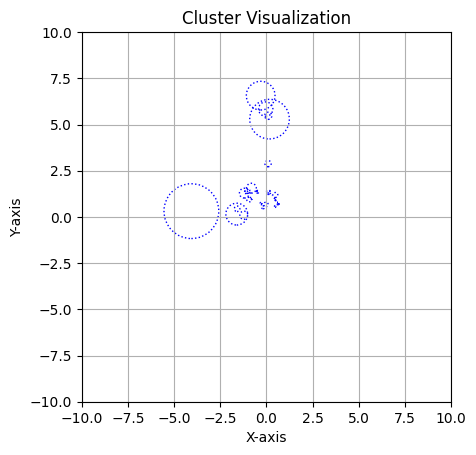

In [15]:
if dim != 2:
    print(f"Dimension {dim} can be visualized using cluster_visualization2D.")
"""Visualization"""
fig, ax = plt.subplots()
for center,radius in zip(cluster_center.values(),cluster_radius.values()):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()

In [16]:
def cluster_boundaries(center_point,radius):
    return np.array([[center_point[i]-radius,center_point[i]+radius]for i in range (len(center_point))])

In [17]:
roots = []
roots_values = []
for i in range (len(cluster_center)):
    bound = cluster_boundaries(cluster_center[i],cluster_radius[i])
    lp = bound[:,0]
    hp = bound[:,1]
    root,value = spo.SpiralOpt(lp,hp,objective_function,dim=dim,npoint=m,r = r,theta=theta, iter_max=k_max, error_max = 10**(-5),random=0, show_err=False, show_objective_function=False)
    roots.append(root)
    roots_values.append(value)
roots,roots_values

([[-0.9537325161667238, 1.0462740200729737],
  [-0.9460030303251447, 1.0539845283043974],
  [-5.439697984714359, -0.16200538903254],
  [-0.15528539304765945, 6.439832073209614],
  [0.16341179837299807, 6.119423929112942],
  [0.1633270747075405, 6.122427335625973],
  [0.1671258978604891, 5.6378510411955505],
  [-1.2793324805427502, 0.7195240238613789],
  [0.04762030596057782, 3.0439601370681872],
  [-1.4141682038548533, -0.09823719221063197],
  [0.18963089015081028, 1.3185890605017976],
  [0.6754982431664561, 0.6928434400468767],
  [-1.4508813056150833, 0.5394736241004501],
  [0.6683409762396577, 0.6888730665935872],
  [-0.5450141534498949, 1.4170909929779054],
  [-0.10230210806972834, 0.5967798750628918],
  [-0.326711073698906, 0.7064556981850505],
  [0.36283092977660053, 1.064820189917363],
  [0.22353286865017533, 1.2669690041062478],
  [0.08345819993062373, 0.5748521364677409],
  [0.44036089028943143, 0.5926284011988512],
  [0.6494378162052885, 0.6961356471479125],
  [-0.700556828588

In [18]:
if dim == 1:
    list_criteria = [element for sublist in roots for element in sublist] #convert from 2D array into 1D array
else:
    list_criteria = roots
eligible_roots = np.array([x for x in list_criteria if (1-objective_function(x))<epsilon])
eligible_roots

array([[-0.15528539,  6.43983207],
       [ 0.16332707,  6.12242734],
       [ 0.66711628,  0.69010219],
       [ 0.66680463,  0.69001708]])

In [19]:
duplicated_roots = []
for i in range(len(eligible_roots)):
    for j in range (i+1,len(eligible_roots)):
        if np.linalg.norm(eligible_roots[i]-eligible_roots[j])<delta:
            duplicated_roots.append([eligible_roots[i],eligible_roots[j]])
duplicated_roots = np.unique(duplicated_roots,axis=0)
# print(duplicated_roots)
deselected_duplicated_roots = []
for i in range (len(duplicated_roots)):
    root_a = objective_function(duplicated_roots[i][0])
    root_b = objective_function(duplicated_roots[i][1])
    if dim == 1:
        if root_a>root_b:
            duplicated_root = duplicated_roots[i][1]
        else:
            duplicated_root = duplicated_roots[i][0]
    else:
        if root_a>root_b:
            duplicated_root = list(duplicated_roots[i][1])
        else:
            duplicated_root = list(duplicated_roots[i][0])
    deselected_duplicated_roots.append(duplicated_root)
# print(deselected_duplicated_roots)
if dim == 1:
    # Reshape the 1D array to have one column
    deselected_duplicated_roots = np.array(deselected_duplicated_roots).reshape(-1, 1)

    # Compare the 2D array with the reshaped 1D array
    exclude_condition = np.all(eligible_roots != deselected_duplicated_roots, axis=0)

    # Use the boolean mask to filter eligible_roots
    final_root = eligible_roots[exclude_condition]
else:
    if deselected_duplicated_roots:
        exclude_condition = np.all(eligible_roots != np.array(deselected_duplicated_roots)[:, np.newaxis], axis=2).all(axis=0)
        final_root = eligible_roots[exclude_condition]
    else:
        final_root = eligible_roots

final_root

array([[-0.15528539,  6.43983207],
       [ 0.16332707,  6.12242734],
       [ 0.66711628,  0.69010219]])

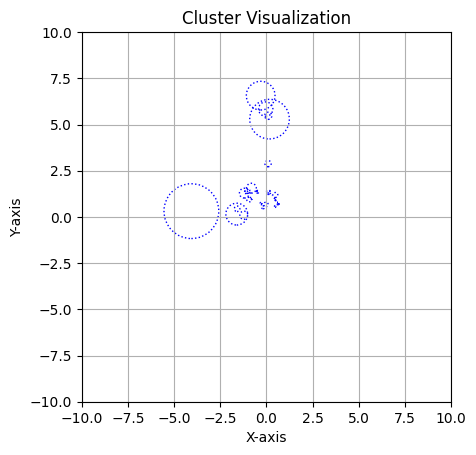

In [20]:
"""Visualization"""
fig, ax = plt.subplots()
for center,radius in zip(cluster_center.values(),cluster_radius.values()):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()
